# Untitled Notebook

What's this notebook about?

/cluster/ggs_lab/mtparker/.conda/envs/nb_rpy2/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


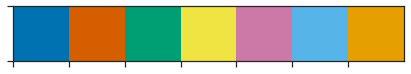

In [1]:
import sys
import re
import os
from glob import glob
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib_venn as vn
import seaborn as sns

from rpy2 import robjects as robj
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter


edgeR = importr('edgeR')
limma = importr('limma')


import pysam

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#56b4e9', '#e69f00'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
def bed_iterator(bed_fn):
    with open(bed_fn) as bed:
        for record in bed:
            chrom, start, end, locus_id, _, strand, *_ = record.split('\t')
            start = int(start)
            end = int(end)
            yield chrom, start, end, locus_id, strand


def calculate_expression(bam_fn, bed_fn):
    exprs = {}
    with pysam.AlignmentFile(bam_fn) as bam:
        for chrom, start, end, gene_id, strand in bed_iterator(bed_fn):
            exprs[gene_id] = bam.count(chrom, start, end)
    return exprs


def read_count_data(bam_fns, bed_fn):
    counts = {}
    for bam_fn in bam_fns:
        print(bam_fn)
        sn = re.search('aligned_data/(.+).bam$', bam_fn).group(1)
        counts[sn] = calculate_expression(bam_fn, bed_fn)
    return pd.DataFrame(counts)


def to_r_dataframe(pd_df):
    with localconverter(robj.default_converter + pandas2ri.converter):
        r_from_pd_df = robj.conversion.py2rpy(pd_df)
    return r_from_pd_df


def to_pd_dataframe(sobj):
    with localconverter(robj.default_converter + pandas2ri.converter):
        pd_from_r_df = robj.conversion.rpy2py(robj.r('as.data.frame')(sobj))
    return pd_from_r_df


def create_dgelist(counts, design_matrix):
    _create_dgelist = robj.r('''
        function (counts, design_matrix) { 
            y <- DGEList(counts=as.matrix(counts))
            y <- calcNormFactors(y)
            keep <- rowSums(edgeR::cpm(y) > 1) >= 2
            y <- y[keep, keep.lib.sizes=FALSE]
            y <- estimateDisp(y, design=design_matrix)
            return (y)
        }
    ''')
    dgelist = _create_dgelist(counts, design_matrix)
    return dgelist


def get_de(dgelist, design, cntrl_cond, treat_cond):
    fit = edgeR.glmFit(dgelist, design)
    contrast = limma.makeContrasts(f'{treat_cond} - {cntrl_cond}', levels=design)
    c_fit = edgeR.glmLRT(fit, contrast=contrast)
    return c_fit


def cfit_to_df(dgelist, c_fit):
    cpm = edgeR.cpm(dgelist, log=True)
    cpm_df = to_pd_dataframe(cpm)
    tt = edgeR.topTags(c_fit, n=np.inf, adjust_method='BH', sort_by='none')
    tt_df = to_pd_dataframe(tt)
    tt_df = tt_df.join(cpm_df, how='outer')
    return tt_df


def run_edgR(counts, design_matrix, cntrl_name, treat_name):
    dgelist = create_dgelist(counts, design_matrix)
    c_fit = get_de(dgelist, design_matrix, cntrl_name, treat_name)
    return cfit_to_df(dgelist, c_fit)
    

def run_differential_histone(counts, cntrl_name, treat_name):
    design_matrix = pd.get_dummies(
        counts.columns.str.split('_', expand=True).get_level_values(0),
        dtype='int32'
    )
    design_matrix.index = counts.columns
    counts = to_r_dataframe(counts)
    design_matrix = to_r_dataframe(design_matrix)
    return run_edgR(counts, design_matrix, cntrl_name, treat_name)

In [4]:
BAM_FNS

[]

In [5]:
BED_FN = '../nanopore_apa_pipeline/pipeline/apa_results/35SFPA_vs_col0.apa_results.bed'
BAM_FNS = glob('../chipseq_pipeline/pipeline/inagaki_et_al_ibm1_h3k9me2/aligned_data/*.bam')

inagaki_counts = read_count_data(BAM_FNS, BED_FN)
inagaki_ibm1_res = run_differential_histone(inagaki_counts, 'col0', 'ibm1')

../chipseq_pipeline/pipeline/inagaki_et_al_ibm1_h3k9me2/aligned_data/ibm1_1.bam
../chipseq_pipeline/pipeline/inagaki_et_al_ibm1_h3k9me2/aligned_data/col0_2.bam
../chipseq_pipeline/pipeline/inagaki_et_al_ibm1_h3k9me2/aligned_data/col0_1.bam
../chipseq_pipeline/pipeline/inagaki_et_al_ibm1_h3k9me2/aligned_data/ibm1_2.bam


In [6]:
BED_FN = '/cluster/ggs_lab/mtparker/papers/fpa_rpp7/nanopore_apa_pipeline/pipeline/apa_results/35SFPA_vs_col0.apa_results.bed'
BAM_FNS = glob('../chipseq_pipeline/pipeline/lai_et_al_ibm1_h3k9me2/aligned_data/*.bam')

lai_counts = read_count_data(BAM_FNS, BED_FN)
lai_ibm1_res = run_differential_histone(lai_counts, 'col0', 'ibm1')

../chipseq_pipeline/pipeline/lai_et_al_ibm1_h3k9me2/aligned_data/ibm1_1.bam
../chipseq_pipeline/pipeline/lai_et_al_ibm1_h3k9me2/aligned_data/col0_2.bam
../chipseq_pipeline/pipeline/lai_et_al_ibm1_h3k9me2/aligned_data/col0_1.bam
../chipseq_pipeline/pipeline/lai_et_al_ibm1_h3k9me2/aligned_data/ibm1_2.bam


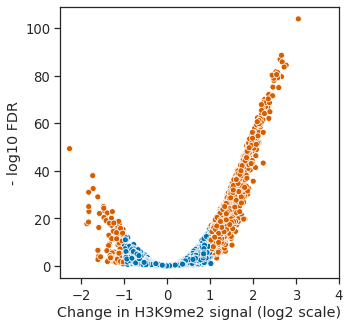

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    x=inagaki_ibm1_res.logFC,
    y=-np.log10(inagaki_ibm1_res.FDR + np.finfo('float64').tiny),
    hue=(inagaki_ibm1_res.FDR < 0.05) & (inagaki_ibm1_res.logFC.abs() > 1),
    legend=False
)
ax.set_xlim(-2.5, 4)
ax.set_xlabel('Change in H3K9me2 signal (log2 scale)')
ax.set_ylabel('- log10 FDR')
plt.show()

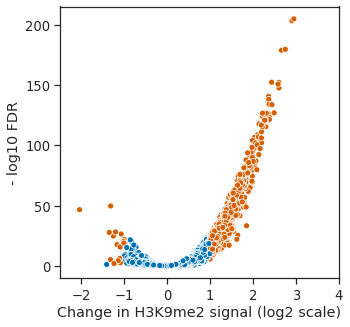

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    x=lai_ibm1_res.logFC,
    y=-np.log10(lai_ibm1_res.FDR + np.finfo('float64').tiny),
    hue=(lai_ibm1_res.FDR < 0.05) & (lai_ibm1_res.logFC.abs() > 1),
    legend=False
)
ax.set_xlim(-2.5, 4)
ax.set_xlabel('Change in H3K9me2 signal (log2 scale)')
ax.set_ylabel('- log10 FDR')
plt.show()

In [9]:
RESULTS_COLUMNS = [
    'chrom', 'start', 'end', 'locus_id', 'score', 'strand',
    'wass_dist', 'wass_dir', 'wass_pval', 'wass_fdr',
    'nreads_cntrl', 'nreads_treat'
]


FPAox_vs_col0 = pd.read_csv(
    '/cluster/ggs_lab/mtparker/papers/fpa_rpp7/nanopore_apa_pipeline/pipeline/apa_results/35SFPA_vs_col0.apa_results.bed',
    sep='\t',
    names=RESULTS_COLUMNS
)

FPAox_vs_col0.head()

,chrom,start,end,locus_id,score,strand,wass_dist,wass_dir,wass_pval,wass_fdr,nreads_cntrl,nreads_treat
0,1,5885,13714,RLOC_00000002,384,-,383.6,-382.9,0.1620,0.446,66,89
1,1,31115,33315,RLOC_00000006,13,-,13.2,13.1,0.1180,0.390,208,324
2,1,33364,37871,RLOC_00000008,25,-,24.8,-4.5,0.0988,0.363,189,336
3,1,44797,49306,RLOC_00000011,26,-,26.2,-16.4,0.6110,0.823,774,953
4,1,49908,51210,RLOC_00000012,4,-,3.7,2.0,0.1260,0.400,2226,2866


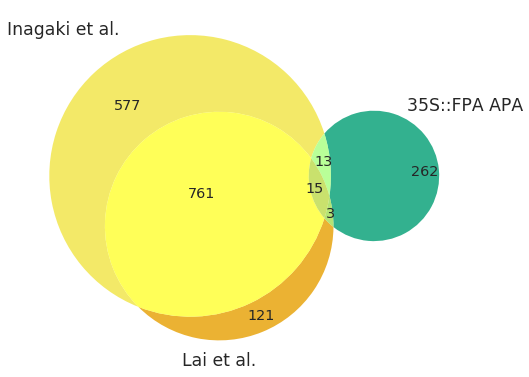

In [11]:
FPAox_apa = set(FPAox_vs_col0.query('wass_fdr < 0.05 & wass_dist > 25').locus_id)
inagaki_ibm1_altered = set(inagaki_ibm1_res.query('FDR < 0.05 & abs(logFC) > 1').index)
lai_ibm1_altered = set(lai_ibm1_res.query('FDR < 0.05 & abs(logFC) > 1').index)

fig, ax = plt.subplots(figsize=(8, 8))

vn.venn3(
    [inagaki_ibm1_altered, FPAox_apa, lai_ibm1_altered],
    set_labels=[
        'Inagaki et al.',
        '35S::FPA APA',
        'Lai et al.',
    ],
    set_colors=[pal[3], pal[2], pal[6]],
    alpha=0.8
)
plt.savefig('figures/ibm1_h3k9me2_35SFPA_apa.svg')
plt.show()

In [14]:
genes_tested_in_both = set(FPAox_vs_col0.locus_id)
ibm1_altered = inagaki_ibm1_altered.union(lai_ibm1_altered)

print(
    len(FPAox_apa.intersection(ibm1_altered)) - 1,
    len(genes_tested_in_both),
    len(ibm1_altered.intersection(genes_tested_in_both)),
    len(FPAox_apa.intersection(genes_tested_in_both)),
)

stats.hypergeom.sf(
    len(FPAox_apa.intersection(ibm1_altered)) - 1,
    len(genes_tested_in_both),
    len(ibm1_altered.intersection(genes_tested_in_both)),
    len(FPAox_apa.intersection(genes_tested_in_both)),
)

30 10499 1490 293


0.9737101493882361

In [17]:
31 / 293

0.10580204778156997

In [16]:
1490 / 10499

0.14191827793123155